# We runnin an equivalent of the old model, with the old data, old anomaly. to see if our model works. yay.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta
import time

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import xskillscore as xs

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed
from eofs.multivariate.standard import MultivariateEof

from scipy import stats
import statsmodels.api as sm

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()
import matplotlib.patches as mpatches

%run og_utils.ipynb

# 1. Load in the model datasets: found in /d6/bxw2101/model_files/datasets.

## We want to load in the smoothed anomaly timeseries.

In [2]:
# LOAD SIC: 1x0.5
filename = '/d6/bxw2101/o_model_files/datasets/sic_1x0p5.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom_smoothed

# LOAD 6 (for now) other model variables: 2x2
filename = '/d6/bxw2101/o_model_files/datasets/vars_2x2.nc'
vars_2x2 = xr.open_dataset(filename)
sst_anom = vars_2x2.sst_anom_smoothed    # 1
sat_anom = vars_2x2.sat_anom_smoothed    # 2
z_anom = vars_2x2.z_anom_smoothed        # 3
u_anom = vars_2x2.u_anom_smoothed        # 4
v_anom = vars_2x2.v_anom_smoothed        # 5
sthf_anom = vars_2x2.sthf_anom_smoothed  # 6

# File naming conventions, selecting # of vars:
var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']

#___ CHANGE the scaling here!
var_scaling = [2, 1, 1, 1, 1, 1, 1]
#var_scaling = [2, 1, 1, 1, 1, 1, 1]
#var_scaling = [2, 1, 1, 0.5, 0.5, 0.5, 0.5]

# GOAL: Get new stds's, then normalize anomalies, so now all of the anomaly std's are = 1. on same scale.

# Calculate new std's, save new stds into one array.
sic_std = sic_anom.std() / var_scaling[0]
sst_std = sst_anom.std() / var_scaling[1]
sat_std = sat_anom.std() / var_scaling[2]
z_std = z_anom.std() / var_scaling[3]
u_std = u_anom.std() / var_scaling[4]
v_std = v_anom.std() / var_scaling[5]
sthf_std = sthf_anom.std() / var_scaling[6]
stds = [sic_std, sst_std, sat_std, z_std, u_std, v_std, sthf_std]

# Normalize the anomalies, save normalized anomalies into one array
norm_sic_anom = sic_anom/sic_std
norm_sst_anom = sst_anom/sst_std
norm_sat_anom = sat_anom/sat_std
norm_z_anom = z_anom/z_std
norm_u_anom = u_anom/u_std
norm_v_anom = v_anom/v_std
norm_sthf_anom = sthf_anom/sthf_std

# Convert normalized anomalies to numpy normalizes anomalies.
np_sic_anom = norm_sic_anom.to_numpy()
np_sst_anom = norm_sst_anom.to_numpy()
np_sat_anom = norm_sat_anom.to_numpy()
np_z_anom = norm_z_anom.to_numpy()
np_u_anom = norm_u_anom.to_numpy()
np_v_anom = norm_v_anom.to_numpy()
np_sthf_anom = norm_sthf_anom.to_numpy()
np_vars = [np_sic_anom, np_sst_anom, np_sat_anom, np_z_anom, np_u_anom, np_v_anom, np_sthf_anom]

# Latitude weight creation
sic_wgts = np.cos(np.deg2rad(sic_anom_ds.coords['y'].values)).clip(0., 1.)[..., np.newaxis]
#     sic_wgts = np.cos(np.deg2rad(sic_anom_ds.y.data))[:, np.newaxis] also works.
vars_wgts = np.cos(np.deg2rad(vars_2x2.coords['y'].values)).clip(0., 1.)[..., np.newaxis]

# defining the different plotting regions right here, and boxing out rectangles for the two regions of interest that we show on poster (dp1, e2)
- we can and should change the eastern regions because I just made them up on my own LMFAO

In [3]:
# Defining the different regions in the Antarctic:
dp1_region = (sic_anom.y >= -70) & (sic_anom.y <= -60) & (sic_anom.x >= 210) & (sic_anom.x <= 230)
dp2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 320) & (sic_anom.x <= 340)
entire_region = True
# my own:
e1_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 0) & (sic_anom.x <= 20)
e2_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 20) & (sic_anom.x <= 40)
e3_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 40) & (sic_anom.x <= 60)
e4_region = (sic_anom.y >= -68) & (sic_anom.y <= -58) & (sic_anom.x >= 140) & (sic_anom.x <= 160)

# define validpoints: Ocean water where there is non-zero sea ice concentration > 5% of the time
filename = '/d6/bxw2101/combined_netcdf_files/new_cdr_sic_monthly_1x0p5.nc'
sic_ds = xr.open_dataset(filename)
sic_var = sic_ds.sic
# freq: Percent of time steps with any valid sea ice value.
freq = sic_var.isel(tdim=slice(2, 266)).where((sic_var < 2.51) & (sic_var > 0)).count(dim='tdim')/264
validpoints = (freq > 0.05)
# sic_anom = sic_anom.where(validpoints)
# HERE, WE DO NOT SET SIC_ANOM TO JUST VALIDPOINTS. MAYBE WE DO THIS BEFORE GETTING THE STDS. 6/13/23

def show_rectangle(ax, x, y, w, h):
    ax.add_patch(mpatches.Rectangle(xy=[x, y], width=w, height=h, 
                                    facecolor='blue', alpha=0.2, transform=pc))
    return ax

In [4]:
# Defining the seasons
seasons = ["DJF", "MAM", "JJA", "SON"]

# Load up the observed SIC anomalies, but chop to their correct time series, and take only valid points.
sic_obs_h = sic_anom.isel(tdim=slice(12, 264)).where(validpoints) # Chop off 1979.
sic_obs_c = sic_anom.isel(tdim=slice(12, 252)).where(validpoints) # Chop off 1979, 2021.
#avg_corrs, avg_rmse = leadtime_plot(2, dp1_region)

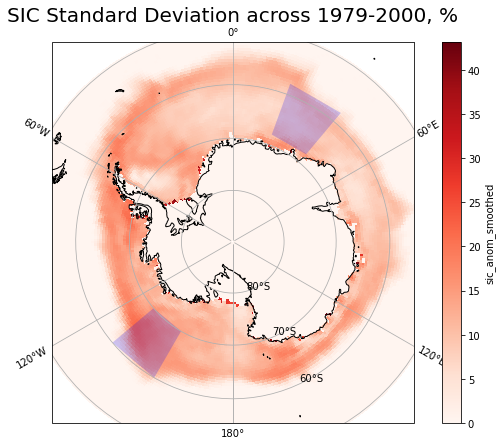

In [5]:
map_sic_std = sic_anom.std(dim='tdim')

# Plot where the region is:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
(map_sic_std * 100).plot(transform=pc, cmap='Reds') 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
show_rectangle(ax, 210, -70, 20, 10) #dp1 region
show_rectangle(ax, 20, -68, 20, 10) #e2 region
ax.set_title('SIC Standard Deviation across 1979-2000, %', fontsize = 20)
plt.show()

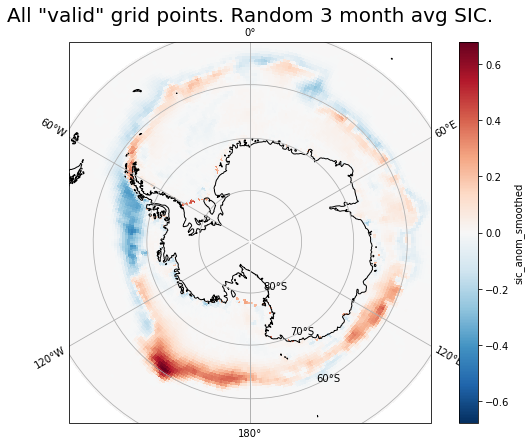

In [6]:
# A Plot of all valid lat/lon cells considered "Valid" in the SIC data
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
sic_anom.sel(tdim='1998-09-01').plot(transform=pc) 
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
ax.set_title('All "valid" grid points. Random 3 month avg SIC.', fontsize=20)
plt.show()

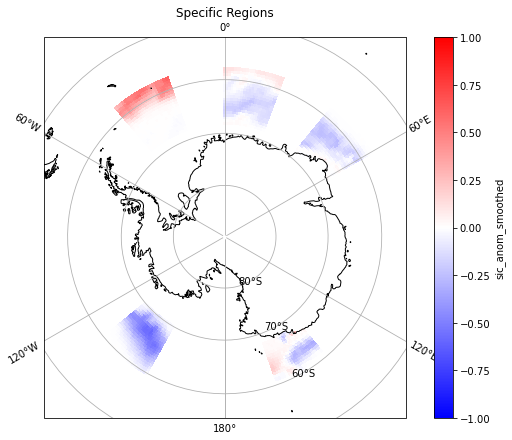

In [7]:
# Plot where a specific region is
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=sp)
sic_obs_h.where(dp2_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr') 
sic_obs_h.where(dp1_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr', add_colorbar = False) 
sic_obs_h.where(e1_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr', add_colorbar = False) 
sic_obs_h.where(e3_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr', add_colorbar = False) 
sic_obs_h.where(e4_region).sel(tdim='1992-07-01').plot(transform=pc, vmin=-1, vmax=1, cmap = 'bwr', add_colorbar = False) 


# fix the damn colorbar axis here. use vmin, vmax, cbarlim, etc. in hindcast_files_analysis.ipynb
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.title('Specific Regions')
plt.show()

(Correlation testing code blocks in **correlation_rmse_testing.ipynb** go here)

# 2. Choose the # of variables and # of modes, to run the hindcast + cross validation markov model creation.

### define the setup_model function below

In [8]:
def setup_model(indices):
    model_vars = [np_vars[x] for x in indices]
    f_start = '_'.join([var_names[x] for x in indices])
    f_scal = '*'.join([str(var_scaling[x]) for x in indices])
    f_name = f_start + '-' + f_scal
    model_wgts = [sic_wgts]
    for x in range(len(indices)-1):
        model_wgts.append(vars_wgts)
    return model_vars, model_wgts, f_name

### HERE: Change the indices, corresponding to the variables you want to include in the model.

In [9]:
# reminder: var_names = ['sic', 'sst', 'sat', 'z', 'u', 'v', 'sthf']
indices = [0, 2, 3, 4, 5] # our best one we think: 0, 1, 2, 6
#indices = [0, 1, 2]
model_vars, model_wgts, f_name = setup_model(indices)
nv = len(indices)
print(f_name)

sic_sat_z_u_v-2*1*1*1*1


### Run the MEOF solver, and hindcast/cross validation model building fortran code.

In [12]:
# We think modes 9-12 are pretty good. Stick w 9 maybe, for final model.
for modes in range(8,9):
    # Give the output a full file name in the format:
    # variables_separated_by_underscores - weights*separated*by*astericks - #ofmodes
    complete_fname = f_name+'-'+ str(modes) + '.nc'
    print('Building hcast and cross for: '+ complete_fname)
    
    # run the solver here.
    solver = MultivariateEof(model_vars,
                         weights = model_wgts, center=False)
    nvars = nv-1 # nvars: number of variables NOT sic. ex. sst, sat: nvars = 2. i=0, 1.
    
    #____________________Solve for MEOFs, PCs
    # define the lat, lon coordinates for the variables.
    sic_lat_bins = np.arange(-89.5, -49.5, 0.5)
    sic_lon_bins = np.arange(0., 360, 1)
    vars_lat_bins = np.arange(-88., -49, 2)
    vars_lon_bins = np.arange(0., 359, 2)

    # get the eofs, pcs, eigenvalues here.
    np_eofs_list = solver.eofs(neofs=modes) # scale by something here?
    np_eofscov_list = solver.eofsAsCovariance(neofs=modes)
    np_pcs = solver.pcs(npcs=modes)
    np_eigs = solver.eigenvalues(neigs=modes) 
    sum_eigs = solver.eigenvalues().sum()
    percent_var = np_eigs.sum() / solver.eigenvalues().sum()
    tav = solver.totalAnomalyVariance()
    vf = solver.varianceFraction()

    # turn the list of eofs for each variable used in the model into SIC_EOFs, and the rest of the eofs.
    sic_eofs = xr.DataArray(np_eofs_list[0],
                           coords = [np.arange(0, modes), sic_lat_bins, sic_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[0]
    all_vars_eofs = [sic_eofs] # all_vars_eofs is eventually what has all the eofs to be plotted.
    for i in range(nvars):
        all_vars_eofs.append(xr.DataArray(np_eofs_list[i + 1],
                           coords = [np.arange(0, modes), vars_lat_bins, vars_lon_bins],
                            dims=['mode', 'y', 'x']) * stds[i + 1])
        
    # for each mode, get the pc timeseries for all the eofs.
    pcs = xr.DataArray(np_pcs, coords=[sic_anom.tdim, np.arange(0, modes)],
                      dims=['tdim', 'mode'])
    
    # Collapse sic_eofs and other eofs from 2d into 1d.
    stacked_sic_eofs = sic_eofs.stack(n=("y","x"))#28800 grid points
    all_stacked_eofs = [stacked_sic_eofs] # all_stacked_eofs is eventually all the stacked eofs.
    for i in range(nvars):
        all_stacked_eofs.append(all_vars_eofs[i+1].stack(n=("y", "x"))) #append a multiple of 3600 grid points
    meofs_2d = xr.concat(all_stacked_eofs, "n") 
    # save the collapsed meofs, and the PC timeseries into files to be ran with fortran.
    np.float32(meofs_2d.data).tofile("/d6/bxw2101/o_model_files/fortran_inputs/meofs")
    np.float32(pcs.transpose("mode", "tdim").data).tofile("/d6/bxw2101/o_model_files/fortran_inputs/pcs")
    numsic = len(stacked_sic_eofs.n)
    numpoints = len(meofs_2d.n)
    nummonths = len(pcs.tdim)
    
    #____________________Run for fortran code
    # Rewrites the input.h file for hindcast creation
    f = open("/home/bxw2101/old_fortran_files/old_hindcast/input.h", "w") 
    inputstr = '''\tPARAMETER(NT=(2000-1979+1)*12,NV='''+str(nv)+''',NL=12,
     % IX1=360,JY1=80,IX2=180,JY2=20,NC=''' + str(modes) + ''',NTY=22,
     % NX1=IX1*JY1,NX2=IX2*JY2,NXT=NX1+NX2*(NV-1),
     % N1=NT,N2=NXT)\n\n'''
    f.write(inputstr)
    f.close()
    
    # Rewrites the input.h file for cross-validation creation
    f = open("/home/bxw2101/old_fortran_files/old_cross/input.h", "w") 
    inputstr = '''\tPARAMETER(NT=(2000-1979+1)*12,NV='''+str(nv)+''',NL=12,
     % IX1=360,JY1=80,IX2=180,JY2=20,NC=''' + str(modes) + ''',NTY=22,
     % NX1=IX1*JY1,NX2=IX2*JY2,NXT=NX1+NX2*(NV-1),
     % N1=NT,N2=NXT)\n\n'''
    f.write(inputstr)
    f.close()
    
    
    # compiles the ./hcast file, runs the ./hcast file. 
    os.system('cd /home/bxw2101/old_fortran_files/old_hindcast; rm -f hcast; make; ./hcast')
    print('\t./hcast file finished')
    # compiles the ./cross file, runs the ./cross file.
    os.system('cd /home/bxw2101/old_fortran_files/old_cross; rm -f cross; make; ./cross')
    print('\t./cross file finished')
    #os.system('ls')
    #os.system('ls')
    
    
    #____________________Retrieve fortran output, turn into python dataarrays. Save zz to file.
    # fortran saves an extra 4 bytes at the front and end to denote logical size: remove them.
    filename = '/home/bxw2101/old_fortran_files/old_hindcast/trans_matrices'
    tmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    filename = '/home/bxw2101/old_fortran_files/old_hindcast/hcast_matrix'
    hmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    filename = '/home/bxw2101/old_fortran_files/old_cross/cross_matrix'
    cmat = np.fromfile(filename, dtype=np.float32)[1:-1]
    
    
    # Load the hindcast transition matrices. in fortran, they are of the form aa(nc, nc, 12)
    aa = np.empty([12, modes, modes])
    for m_i in range(12):
        i_1 = m_i*modes**2
        i_2 = (m_i+1)*modes**2
        a_f = np.reshape(tmat[i_1:i_2], (modes, modes), order='F')
        aa[m_i] = a_f
    #aa currently is not doing anything. we just have, but we do not need.
    # Load the full hindcast array for SIC. in fortran: it is of the form zz(13, nx, nt)
    zz = np.empty([nummonths, 13, numpoints])
    for t_i in range(nummonths):
        i_1 = t_i*numpoints*13
        i_2 = (t_i+1)*numpoints*13
        zz[t_i] = np.reshape(hmat[i_1: i_2], (13, numpoints), order='F')
    zz_da = xr.DataArray(zz,
                           coords = [pcs.tdim, np.arange(13), meofs_2d.n],
                            dims=['tdim', 'lead', 'n'])
    # Load the full cross validation array for SIC. in fortran: it is of the form zz(13, nx1-sic, nt)
    zzc = np.empty([nummonths, 13, numsic])
    for t_i in range(nummonths):
        i_1 = t_i*numsic*13
        i_2 = (t_i+1)*numsic*13
        zzc[t_i] = np.reshape(cmat[i_1: i_2], (13, numsic), order='F')
    zzc_da = xr.DataArray(zzc,
                           coords = [pcs.tdim, np.arange(13), stacked_sic_eofs.n],
                            dims=['tdim', 'lead', 'n'])
    
    # hcast: unstack from 1d num of points back to the original 2d grids of lat/lon.
    stacked_sic_hcast = zz_da.isel(n=slice(0, len(stacked_sic_eofs.n)))
    all_stacked_hcasts = [stacked_sic_hcast] # HERE, we store hcasts in all_stacked_hcasts.
    for i in range(nvars):
        all_stacked_hcasts.append(zz_da.isel(n=slice(len(stacked_sic_eofs.n) + 3600*i, len(stacked_sic_eofs.n) + 3600*(i+1)))) 
    sic_hcast = stacked_sic_hcast.unstack()
    hcastwgts = np.cos(np.deg2rad(sic_hcast.y))
    sic_hcast = sic_hcast / hcastwgts
    sic_hcast = sic_hcast.isel(tdim=slice(12,264))
       
    # save the sic_hcast, the rest of the hcasts should be saved too in the future ig for the plots.
    os.system('cd /d6/bxw2101/o_model_files/hcast_output; rm -f '+complete_fname)
    sic_hcast.to_netcdf('/d6/bxw2101/o_model_files/hcast_output/'+complete_fname, mode='w',format='NETCDF4')

    # cross: unstack from 1d num of points back to the original 2d grids of lat/lon.
    sic_cross = zzc_da.unstack()
    hcastwgts = np.cos(np.deg2rad(sic_cross.y))
    sic_cross = sic_cross / hcastwgts
    sic_cross = sic_cross.isel(tdim=slice(12,252))
 
    # save the sic_cross, the rest of the cross's should be saved too in the future ig for the plots.
    os.system('cd /d6/bxw2101/o_model_files/cross_output; rm -f '+complete_fname)
    sic_cross.to_netcdf('/d6/bxw2101/o_model_files/cross_output/'+complete_fname, mode='w',format='NETCDF4')
    
    print('hcast and cross saved for: ' + complete_fname + '\n')

print('Done!')

Building hcast and cross for: sic_sat_z_u_v-2*1*1*1*1-8.nc
gfortran -O2 hcast.f ../imsl/imsl.a -o hcast
	./hcast file finished
gfortran -O2 cross.f ../imsl/imsl.a -o cross
	./cross file finished
hcast and cross saved for: sic_sat_z_u_v-2*1*1*1*1-8.nc

Done!


### Show the first five modes, and the first [modes] pcs. may include in final poster.
- Scaling to the maximum real value it represents right now.
- Figure out how to show the colorbars well. Also, figure out vmin and vmax for the rest of the variables.

[3200.99095829 1810.94868123 1308.04225848 1143.64228511  976.61888673
  869.52701402  715.42968934  635.26110356]


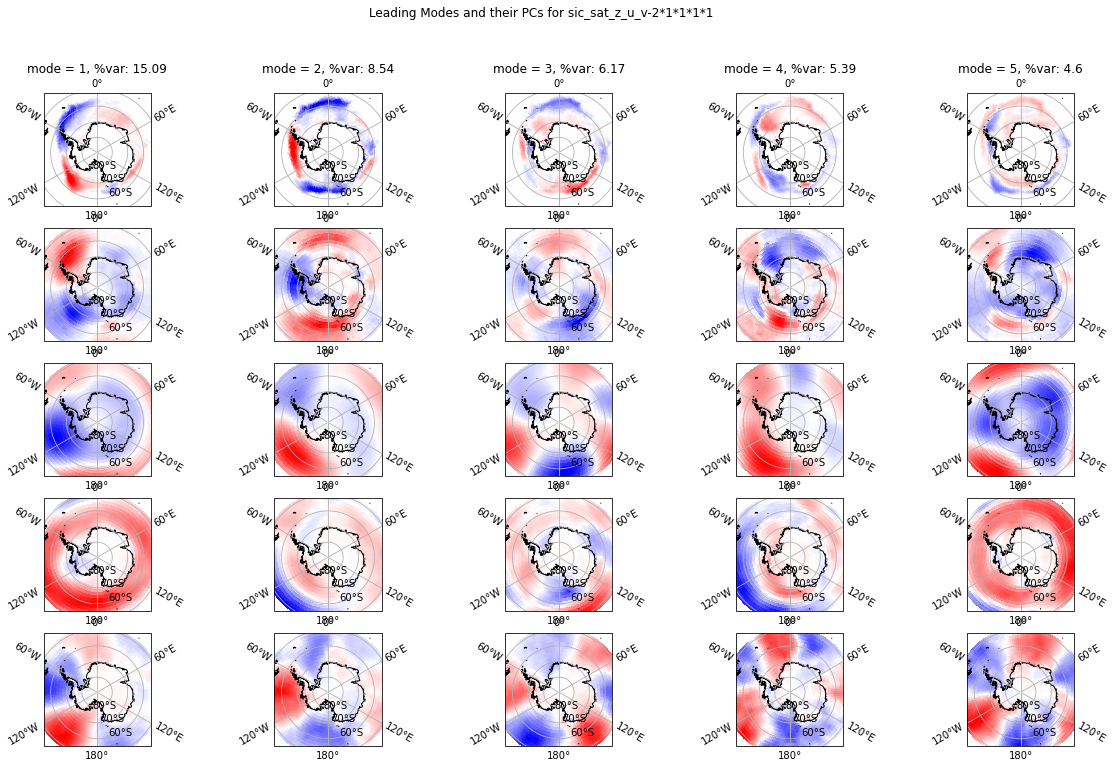

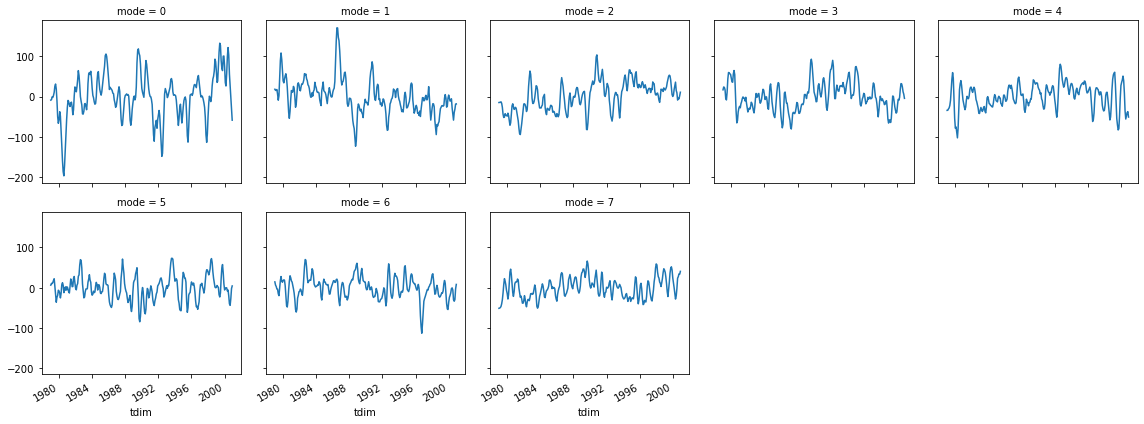

In [13]:
# I can't rly figure out how to scale each mode to the max real value it represents.

fig = plt.figure(figsize=(20,12))
for mode in range(min(5,modes)):
    # SIC EOFs
    ax = plt.subplot(len(indices), 5, mode + 1, projection=sp)
    sic_mode = sic_eofs[mode]*pcs.sel(mode=mode).max()*var_scaling[0]
    
    im = sic_mode.plot(transform=pc, vmin=-.3, vmax=.3, cmap = 'bwr', add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('mode = ' + str(mode+1) + ', %var: ' + str(round(np_eigs[mode]/sum_eigs * 100, 2)))

    
    #OTHER VAR EOFS: all_vars_eofs[i+1] for i in range(nvars)
    for i in range(nvars):
        ax = plt.subplot(len(indices), 5, mode + 1 + 5*(i+1), projection=sp)
        vars_mode = all_vars_eofs[i + 1][mode]*pcs.sel(mode=mode).max()/stds[1]*var_scaling[indices[i+1]]

        im = vars_mode.plot(transform=pc, cmap = 'bwr', add_colorbar=False)
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
        ax.set_title('')
plt.suptitle('Leading Modes and their PCs for ' + f_name)

# Plot corresponding PCs
if modes > 1:
    pcs.plot(x='tdim',col='mode',col_wrap=min(5, modes));
print(solver.eigenvalues(neigs=modes))

# 3. Evaluating hindcast/cross validation model skill: 
# To select the best model: comparing diff modes, & diff vars. & diff weights.

# Running Tests

## Running thru # of modes being 1-20, just like in the model creation loop, and saving the files to their folders:

# of zz matrices to plot: 4
Loaded in sic_sat_z_u_v-2*1*1*1*1-6.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-7.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-8.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-9.nc


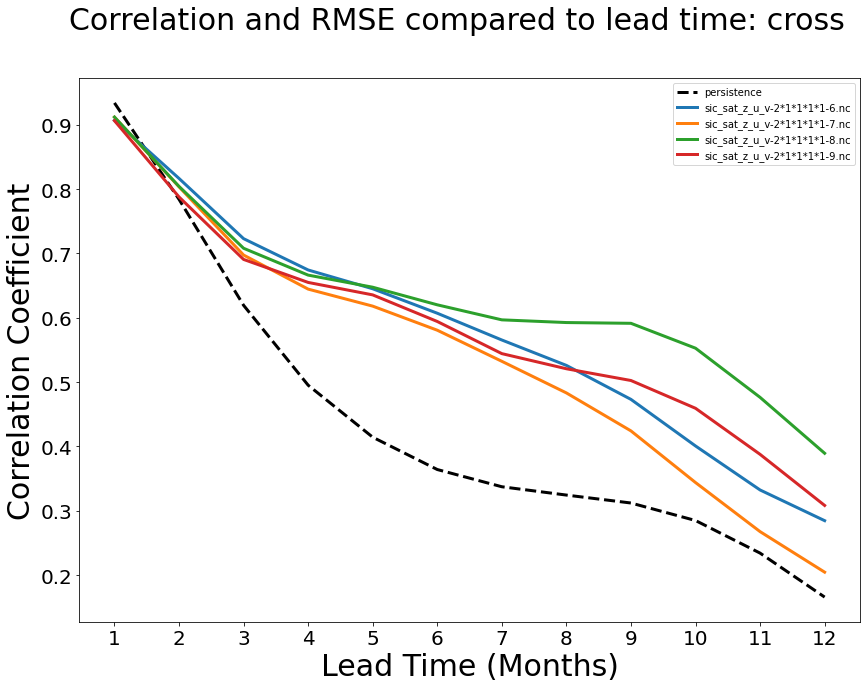

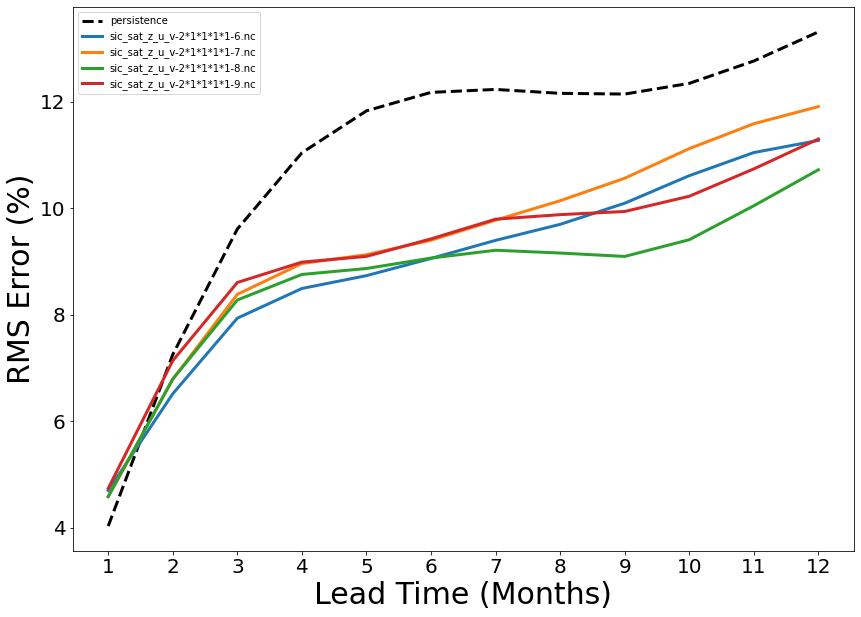

Saved all files!


In [10]:
# Define your variables
#f_name = 'sic_sst_sat_sthf-2*1*1*1' 
matrix_type = 'cross'
mode_comparison = [f_name+'-'+str(i)+'.nc' for i in range(6, 10)]

#Run the plots
ac, ar, pc, pr = leadtime_plot(matrix_type, mode_comparison, dp1_region)

# Save your correlation and rmse files
os.chdir('/d6/bxw2101/o_model_files/'+matrix_type+'_analysis/dp1_region/')
if not os.path.exists(f_name):
    os.mkdir(f_name)
for i in range (len(mode_comparison)):
    np.savetxt('/d6/bxw2101/o_model_files/'+matrix_type+'_analysis/'+'dp1_region/'+f_name+'/'+mode_comparison[i][:-3]+'-corr.txt', ac[i], delimiter=',')
    np.savetxt('/d6/bxw2101/o_model_files/'+matrix_type+'_analysis/'+'dp1_region/'+f_name+'/'+mode_comparison[i][:-3]+'-rmse.txt', ar[i], delimiter=',')
    np.savetxt('/d6/bxw2101/o_model_files/'+matrix_type+'_analysis/'+'dp1_region/persistence-corr.txt', pc, delimiter=',')
    np.savetxt('/d6/bxw2101/o_model_files/'+matrix_type+'_analysis/'+'dp1_region/persistence-rmse.txt', pr, delimiter=',')

print('Saved all files!')



# of zz matrices to plot: 5
Loaded in sic_sat_z_u_v-2*1*1*1*1-5.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-6.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-7.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-8.nc
Loaded in sic_sat_z_u_v-2*1*1*1*1-9.nc


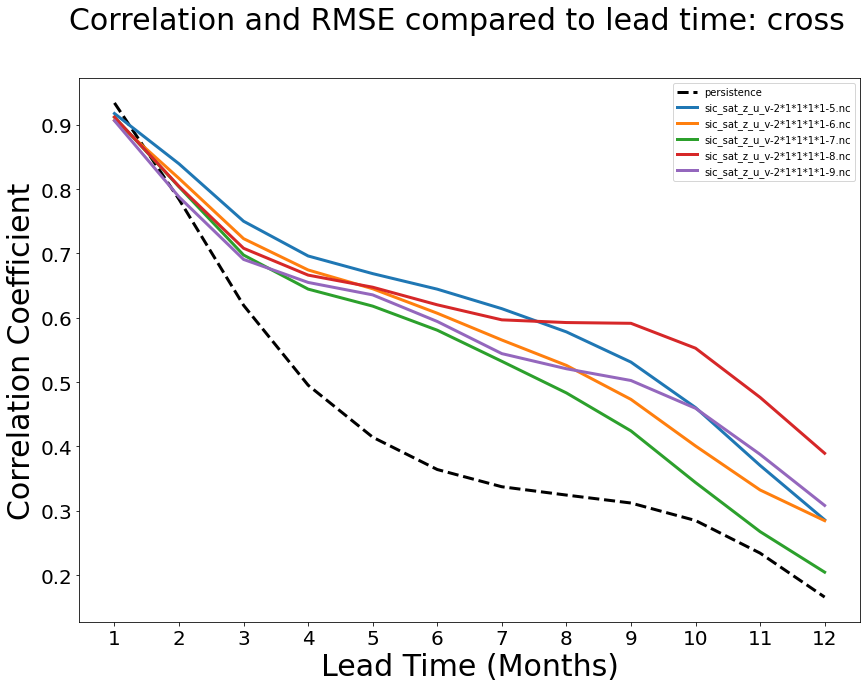

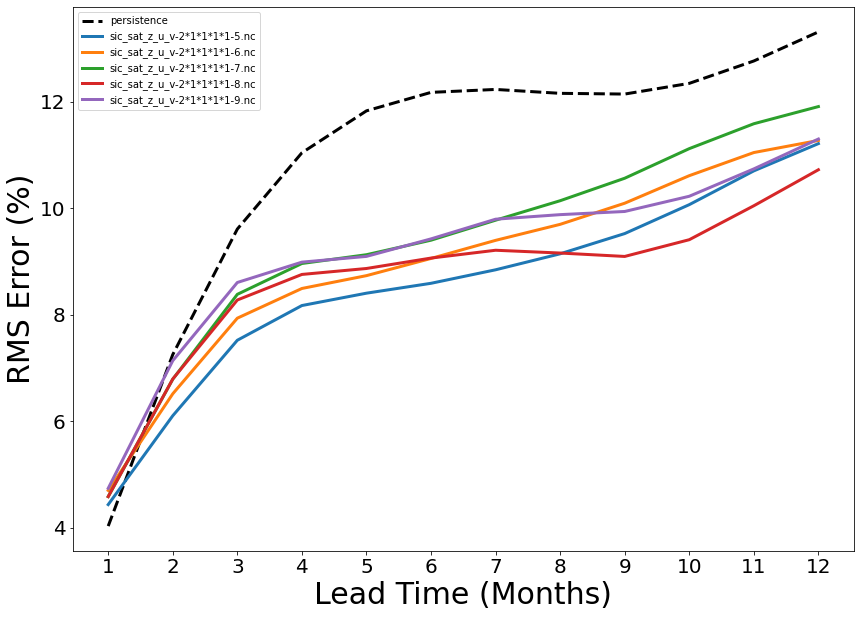

In [14]:
mode_comparison = ['sic_sat_z_u_v-2*1*1*1*1-'+str(i)+'.nc' for i in range(5, 10)]
ac, ar = leadtime_plot('cross', mode_comparison, dp1_region)

# of zz matrices to plot: 2
Loaded in sic_sat_z_u_v-2*1*1*1*1-8.nc
Loaded in sic_sst_sat_z_u_v-2*1*1*1*1*1-8.nc


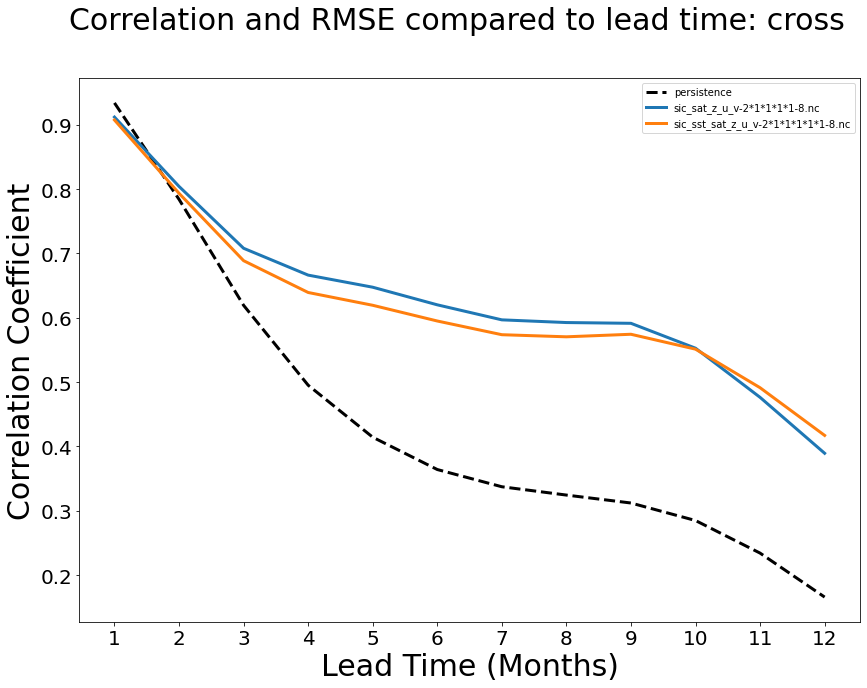

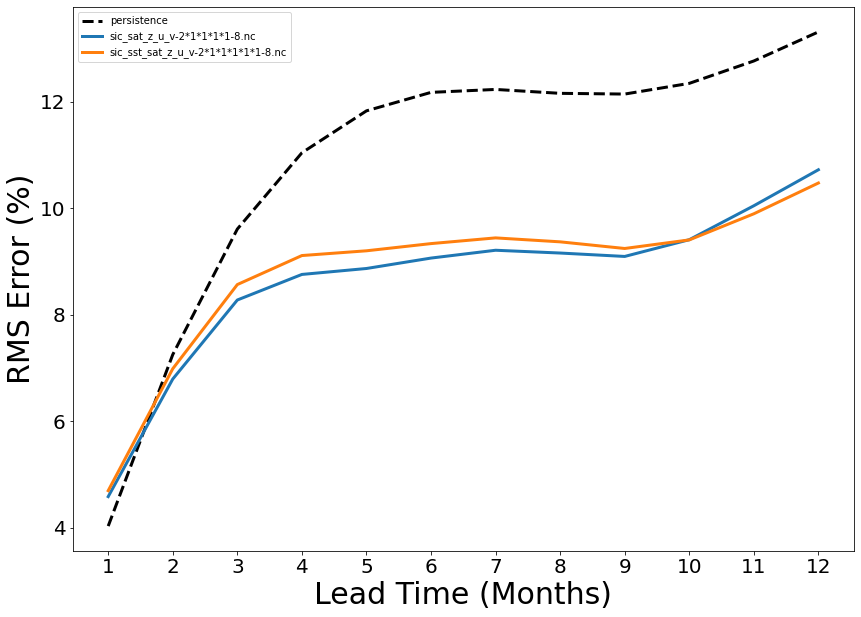

In [55]:
diff_old_vars = ['sic_sat_z_u_v-2*1*1*1*1-8.nc',
                'sic_sst_sat_z_u_v-2*1*1*1*1*1-8.nc']
ac, ar = leadtime_plot('cross', diff_old_vars, dp1_region)